Importação do raw dataset

In [2]:
from google.colab import files

uploaded = files.upload()

Saving carteira_total.xlsx to carteira_total.xlsx


# Importação das bibliotecas necessárias

In [3]:
import re
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

!pip install imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

!pip install unidecode
from unidecode import unidecode

# Biblioteca do PD Profiling abaixo

# Leitura do Documento

In [204]:
df = pd.read_excel('carteira_total.xlsx')

In [205]:
dfBackup = df.copy()

# Pandas Proffling

In [6]:
!pip install -U pandas-profiling
from pandas_profiling import ProfileReport

     |████████████████████████████████| 261 kB 9.0 MB/s 
     |████████████████████████████████| 596 kB 46.9 MB/s 
     |████████████████████████████████| 690 kB 47.4 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 10.9 MB 39.4 MB/s 
     |████████████████████████████████| 3.1 MB 42.4 MB/s 
     |████████████████████████████████| 102 kB 11.5 MB/s 
     |████████████████████████████████| 303 kB 62.7 MB/s 
     |████████████████████████████████| 812 kB 48.3 MB/s 
     |████████████████████████████████| 38.1 MB 58.4 MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=c0b7c42dff11f5be2d1022908b0a989b73dcb105a2beb52661be790a959ac959
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295206 sha256=7a163a10c727bc070ddd0f3a836b7e13b8dad058c39c69bddbf19b9d31d82ff1


In [7]:
prof = ProfileReport(df)
prof.to_file(output_file='output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# EDA

Remoção dos acentos das colunas e alteração dos caracteres diferentes de alfa numérico para "_"

In [206]:
newColumnsName = [];
for column_name in df:
  newColumnsName.append(re.sub('[^A-Za-z0-9]+', '_', unidecode(column_name).lower()))
df.columns = newColumnsName

Criação da coluna churn, e definição do seu valor com base nos valores da coluna upsale_downsale (churn = 1, demais valores = 0). Decidimos excluir a coluna upsell_downsell (por não ter mais importância para a análise)

In [207]:
df["upsale_downsale"].replace({"Churn": "churn", "Upsell": "upsell", "Downsell": "downsell", "Ok": "ok"}, inplace=True)
df['churn'] = df['upsale_downsale']
df['churn'].replace({"ok": "0", "upsell": "0", "downsell": "0", "churn": "1"}, inplace=True)
df['churn'] = df['churn'].astype(int)

df.drop(columns = ["upsale_downsale"], inplace = True)

In [208]:
df.dtypes

mes                           datetime64[ns]
id_crm                                 int64
id_navplat                             int64
id_sap                                 int64
regiao                                object
cidade                                object
bairro                                object
valor_mensal                         float64
valor_hoje                           float64
faturamento                          float64
oficina                               object
frequencia_de_faturamento             object
tipo_de_plano                         object
contratado_super_destaques             int64
contratado_destaques                   int64
contratado_ofertas_simples             int64
contratado_freemium                  float64
utilizado_super_destaques            float64
utilizado_destaque                   float64
utilizado_ofertas_simples            float64
utilizado_freemium                   float64
executivo_carteira_atual              object
equipe    

In [209]:
# Missing Values
# contratado_freemium (52.1%) - Quantidade de zeros (25.9%)
# utilizado_freemium (52.1%) - Quantidade de zeros (44.5%)

# possui_midia_ativa_ (0.6%) - categorica
# custo_por_lead_total (0.4%)
# total_contratado (0.4%)
# utilizado_super_destaques (< 0.1%)
# utilizado_destaque (< 0.1%)
# utilizado_ofertas_simples (< 0.1%)
# leads_form (< 0.1%)
# leads_ver_dato (< 0.1%)
# leads_total (< 0.1%)
# custo_por_listing (< 0.1%)
# total_utilizado (< 0.1%)
# faixa_listings (< 0.1%) - categorica

## Padronizando valores categóricos

###Oficina

In [210]:
df['oficina'].unique()

array(['WI', 'IW'], dtype=object)

In [211]:
df['oficina'].replace({'wi': 'WI'}, inplace=True) # Alterando o valor wi para igualar a WI
df['oficina'].unique()

array(['WI', 'IW'], dtype=object)

###Faturamento

In [212]:
df['frequencia_de_faturamento'].unique()

array(['Mensal', 'Anual', 'Semestral', 'Trimestral', 'MENSAL', 'ANUAL',
       'SEMESTRAL', 'TRIMESTRAL', 0], dtype=object)

In [213]:
#corrigir diferenças de nomes
df['frequencia_de_faturamento'] = df['frequencia_de_faturamento'].str.lower()
df['frequencia_de_faturamento'].unique()

array(['mensal', 'anual', 'semestral', 'trimestral', nan], dtype=object)

In [214]:
#remover espaços

df['frequencia_de_faturamento'] = df['frequencia_de_faturamento'].str.strip()
df['frequencia_de_faturamento'].unique()

array(['mensal', 'anual', 'semestral', 'trimestral', nan], dtype=object)

In [215]:
#renomeando unica vez

df['frequencia_de_faturamento'].replace({'única vez': 'unica_vez'}, inplace=True)
df['frequencia_de_faturamento'].unique()

array(['mensal', 'anual', 'semestral', 'trimestral', nan], dtype=object)

###Tipo de Plano

In [216]:
df['tipo_de_plano'].unique()

array(['LIMITADO', 'ILIMITADO', nan, 'SIMPLES', 'PACK', 0], dtype=object)

###Midia Ativa

In [217]:
df['possui_midia_ativa_'].unique()

array(['No', 'Si', nan], dtype=object)

###PF_PJ

In [218]:
df['pf_pj'].unique()

array(['PJ', 'PF'], dtype=object)

###Equipe

In [219]:
df['equipe'].unique()

array(['Regional DF', 'Relacionamento', 'JUMBO', 'Resellers', 'Jumbo',
       'Mídias', 'RELACIONAMENTO', 'RESELLERS', 'REGIONAL DF'],
      dtype=object)

In [220]:
df['equipe'].replace({'Relacionamento': 'RELACIONAMENTO','Jumbo':'JUMBO','Resellers':'RESELLERS'}, inplace=True) # Alterando para valores ficarem iguais
df['equipe'].unique()

array(['Regional DF', 'RELACIONAMENTO', 'JUMBO', 'RESELLERS', 'Mídias',
       'REGIONAL DF'], dtype=object)

In [221]:
df.columns

Index(['mes', 'id_crm', 'id_navplat', 'id_sap', 'regiao', 'cidade', 'bairro',
       'valor_mensal', 'valor_hoje', 'faturamento', 'oficina',
       'frequencia_de_faturamento', 'tipo_de_plano',
       'contratado_super_destaques', 'contratado_destaques',
       'contratado_ofertas_simples', 'contratado_freemium',
       'utilizado_super_destaques', 'utilizado_destaque',
       'utilizado_ofertas_simples', 'utilizado_freemium',
       'executivo_carteira_atual', 'equipe', 'status_final',
       'possui_midia_ativa_', 'leads_form', 'leads_ver_dato', 'leads_total',
       'custo_por_lead_total', 'total_contratado', 'total_de_listings',
       'custo_por_listing', 'pf_pj', 'total_utilizado', 'faixa_listings',
       'churn'],
      dtype='object')



---



## Drop das colunas "contratado_freemium" e "utilizado_freemium" por possuírem diversos valores nulos e zerados

In [222]:
df.drop(['contratado_freemium', 'utilizado_freemium'], axis=1, inplace=True)

## Analise Grafica

### Análise região (não aparenta influenciar no churn)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


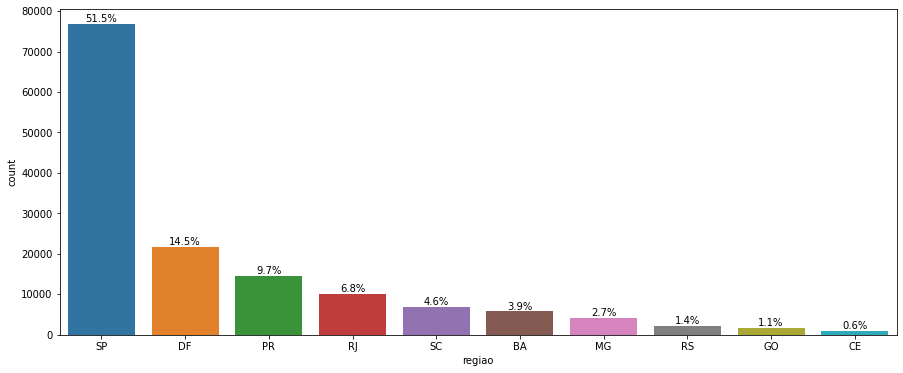

In [223]:
serie_filtrada = df["regiao"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


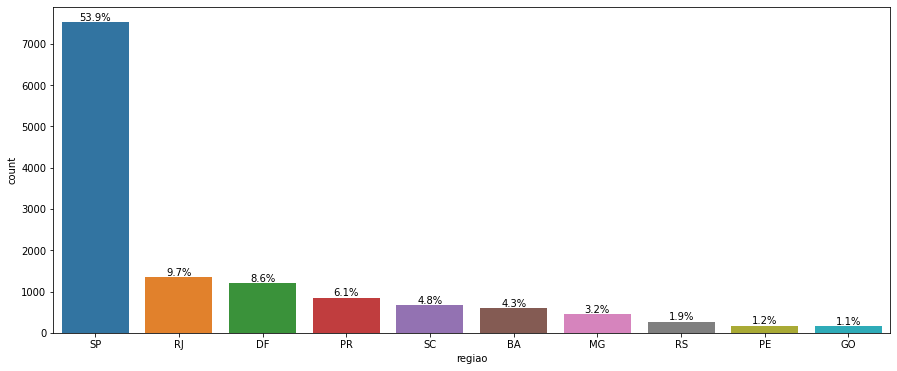

In [224]:
serie_filtrada = df[df["churn"] == 1]["regiao"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Cidade (não aparenta influenciar no churn)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


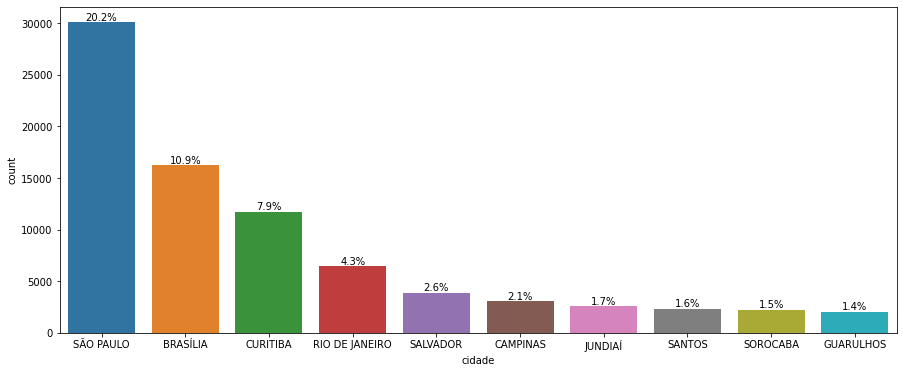

In [225]:
serie_filtrada = df["cidade"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


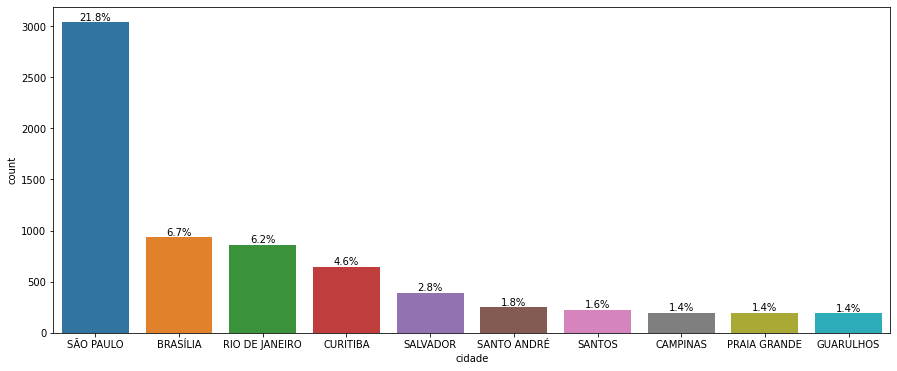

In [226]:
serie_filtrada = df[df["churn"] == 1]["cidade"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Oficina (não aparenta influenciar no churn)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


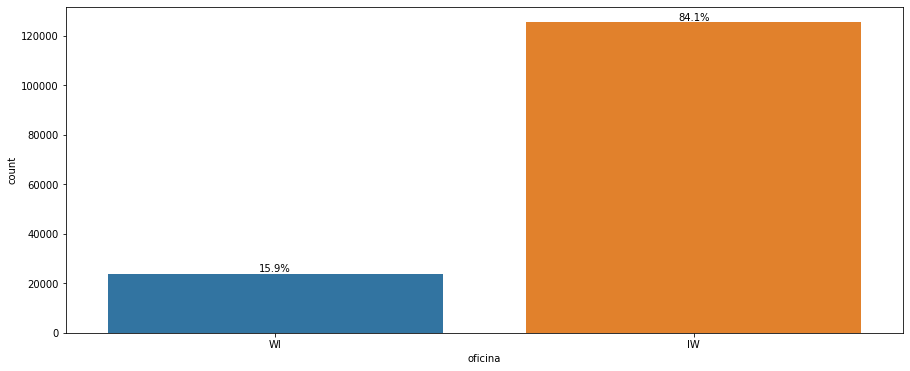

In [227]:
serie_filtrada = df["oficina"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


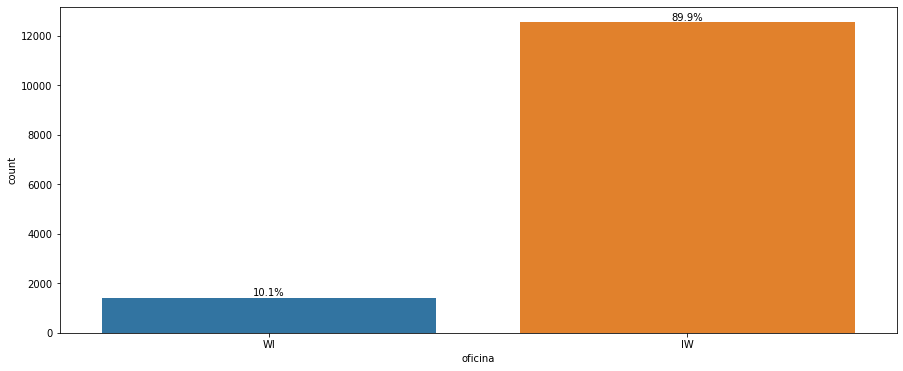

In [228]:
serie_filtrada = df[df["churn"] == 1]["oficina"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Frequência Faturamento (não aparenta influenciar no churn)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


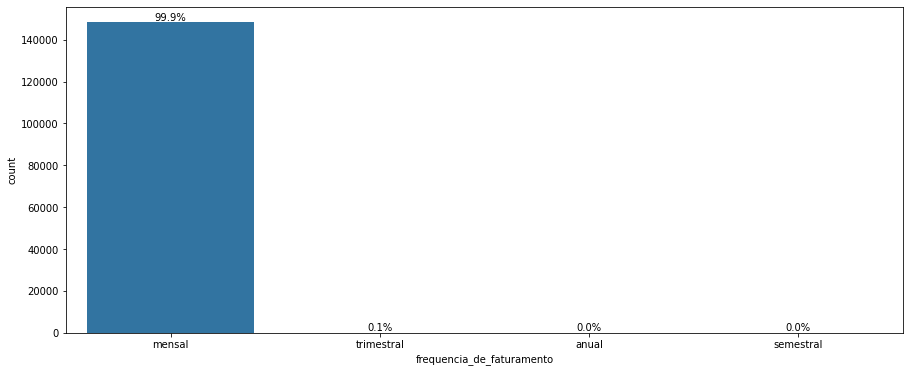

In [229]:
serie_filtrada = df["frequencia_de_faturamento"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


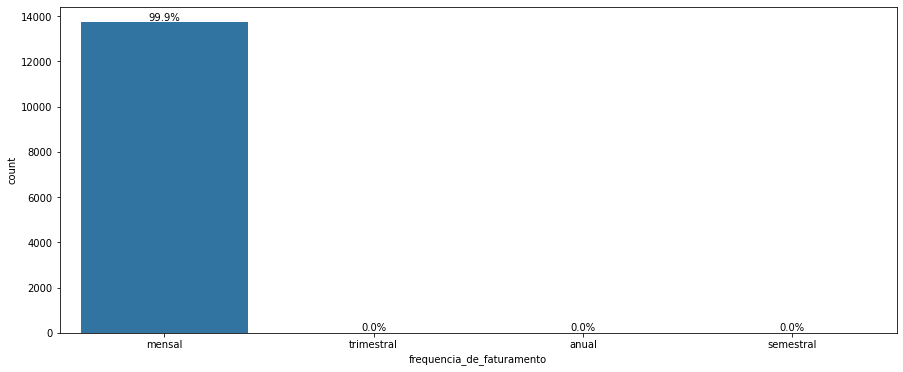

In [230]:
serie_filtrada = df[df["churn"] == 1]["frequencia_de_faturamento"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Tipo de Plano (pode influenciar no churn)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


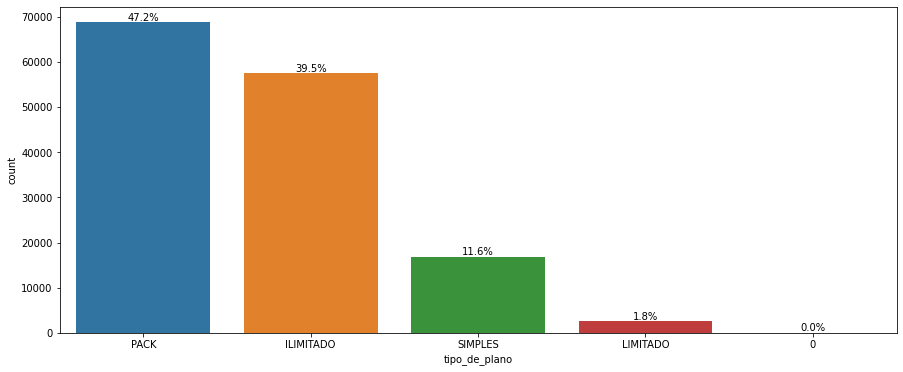

In [231]:
serie_filtrada = df["tipo_de_plano"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


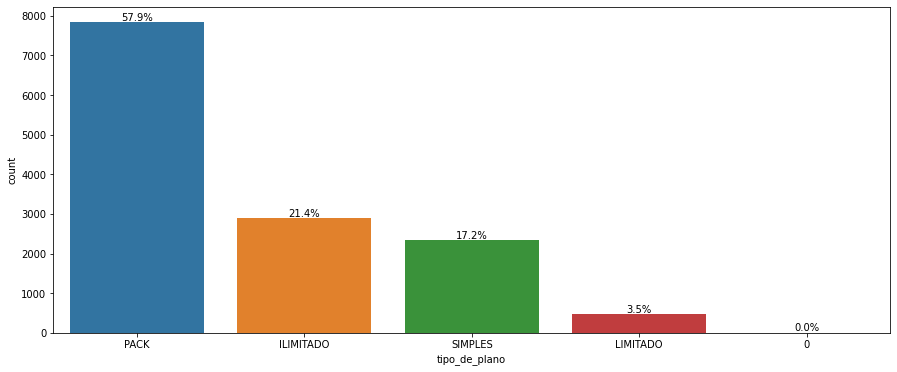

In [232]:
serie_filtrada = df[df["churn"] == 1]["tipo_de_plano"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Executivo Carteira Atual (não aparenta influenciar no churn)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


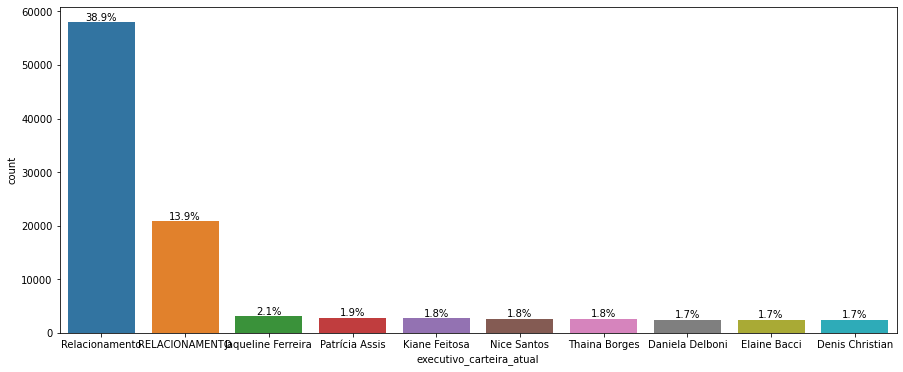

In [233]:
serie_filtrada = df["executivo_carteira_atual"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


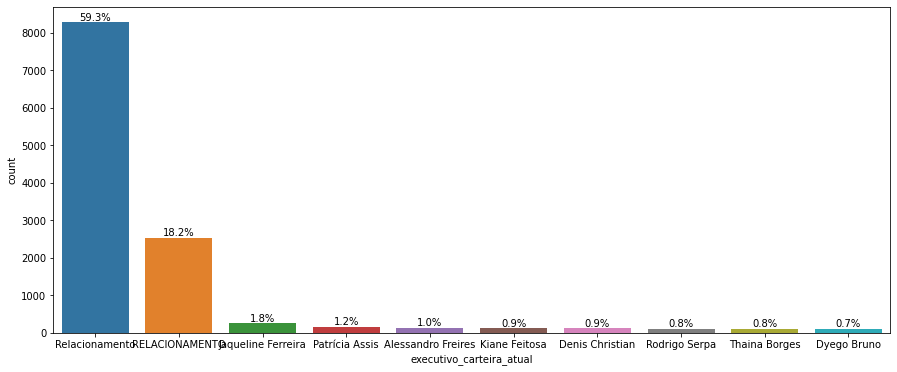

In [234]:
serie_filtrada = df[df["churn"] == 1]["executivo_carteira_atual"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Equipe (pode influenciar no churn)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


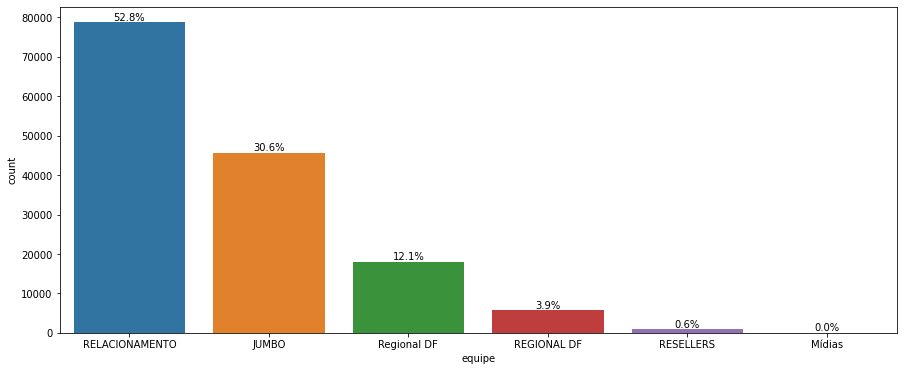

In [235]:
serie_filtrada = df["equipe"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


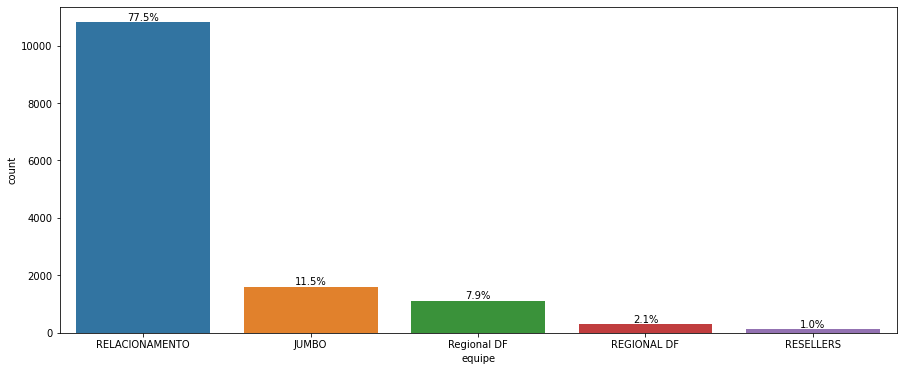

In [236]:
serie_filtrada = df[df["churn"] == 1]["equipe"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Status Final (alta correlação com churn, talvez não seja interessante manter)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


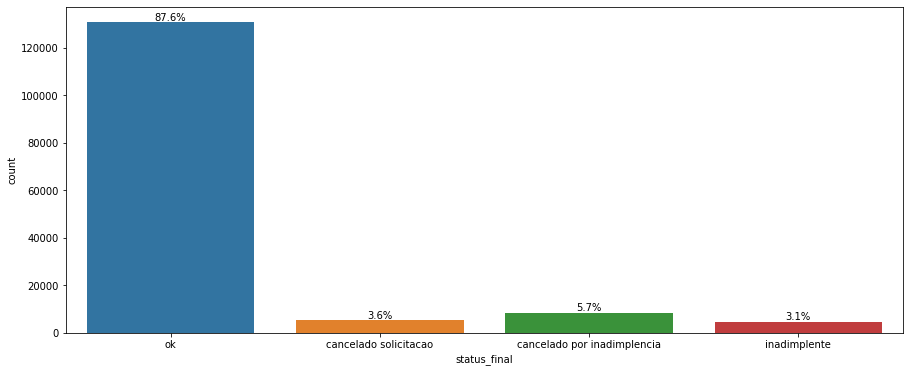

In [237]:
serie_filtrada = df["status_final"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


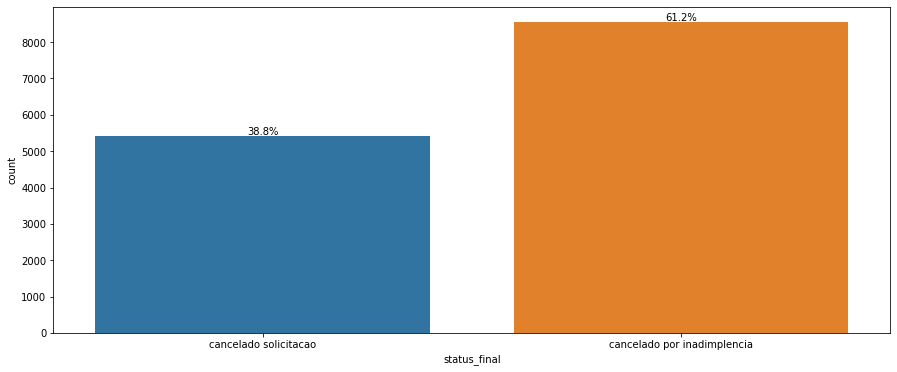

In [238]:
serie_filtrada = df[df["churn"] == 1]["status_final"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Possui Midia Ativa (pode ter influencia no churn, mas muito pouco)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


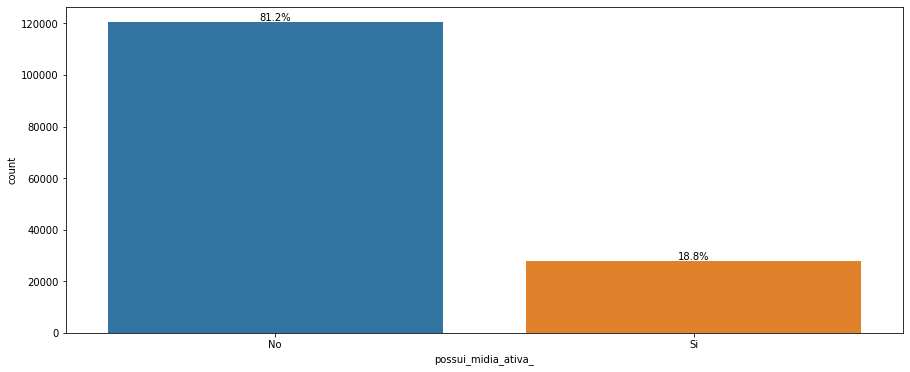

In [239]:
serie_filtrada = df["possui_midia_ativa_"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


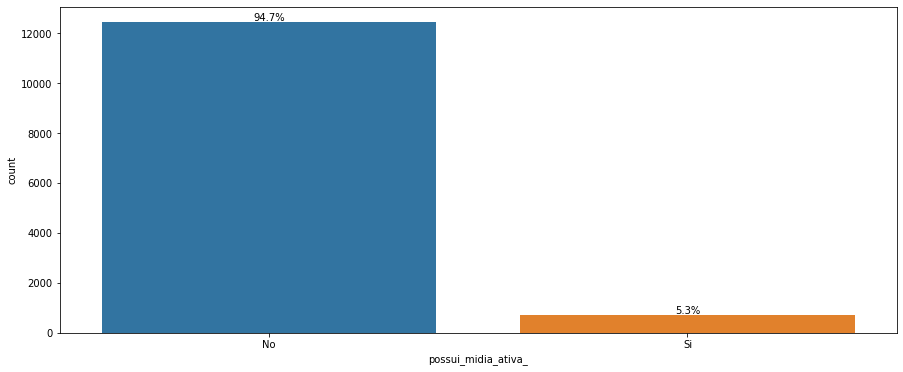

In [240]:
serie_filtrada = df[df["churn"] == 1]["possui_midia_ativa_"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Pessoa Física Jurídica (relação forte com o churn)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


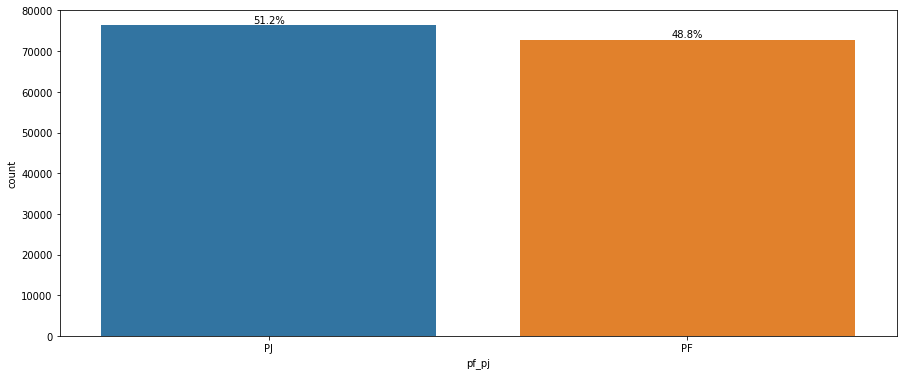

In [241]:
serie_filtrada = df["pf_pj"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


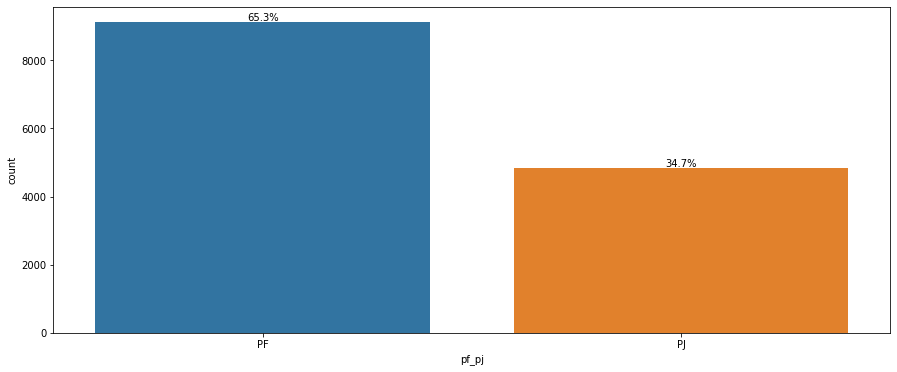

In [242]:
serie_filtrada = df[df["churn"] == 1]["pf_pj"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Faixa Listings (relação forte com o churn)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


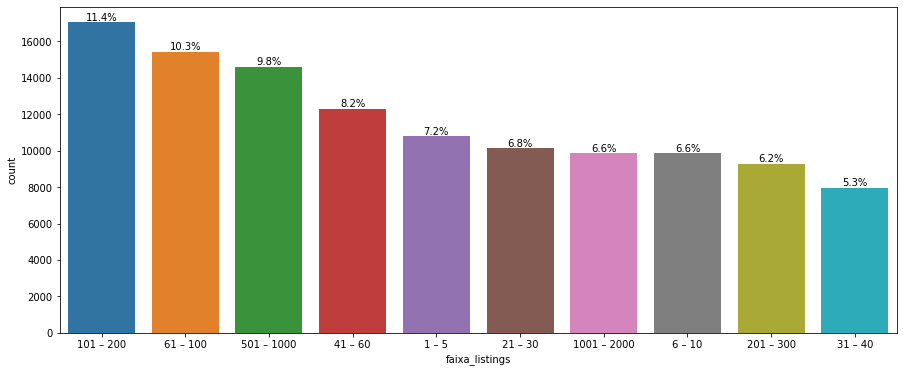

In [243]:
serie_filtrada = df["faixa_listings"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


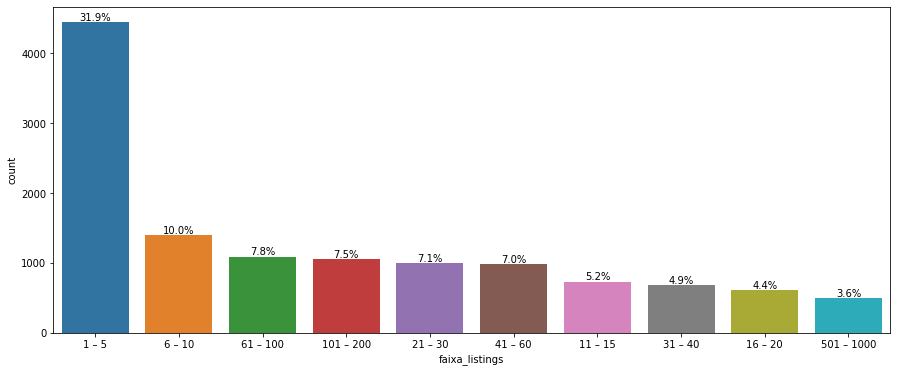

In [244]:
serie_filtrada = df[df["churn"] == 1]["faixa_listings"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

Template

### Análise Valor Mensal (pode influenciar no churn, mas pouco)

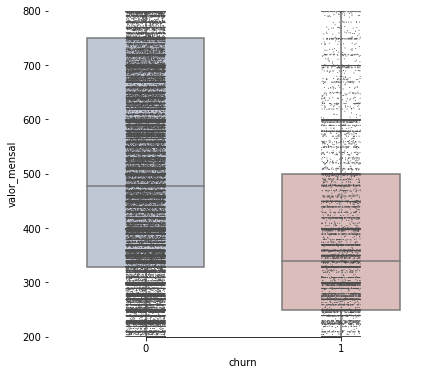

In [245]:
coluna_medida = "valor_mensal"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((200, 800))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Valor Hoje (alta correlação com churn. Talvez seja melhor remover)

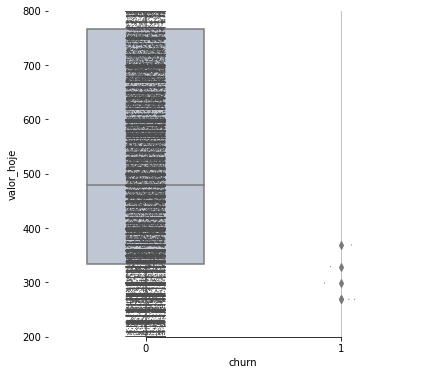

In [246]:
coluna_medida = "valor_hoje"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((200, 800))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Faturamento (Alta correlação com churn. Talvez seja melhor tirar)

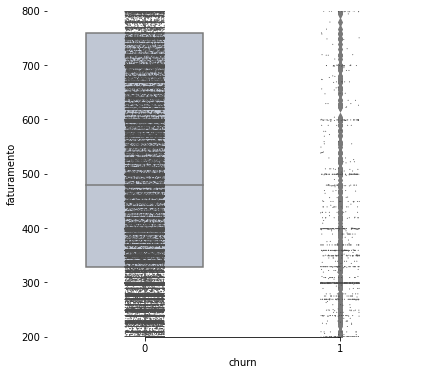

In [247]:
coluna_medida = "faturamento"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((200, 800))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Contratado Super Destaques (pode influenciar no churn)

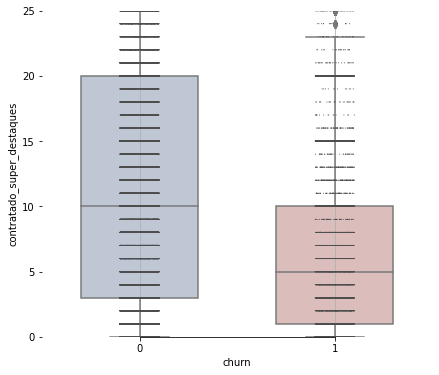

In [248]:
coluna_medida = "contratado_super_destaques"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 25))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)

### Análise Contratado Destaques (não aparenta influenciar no churn)

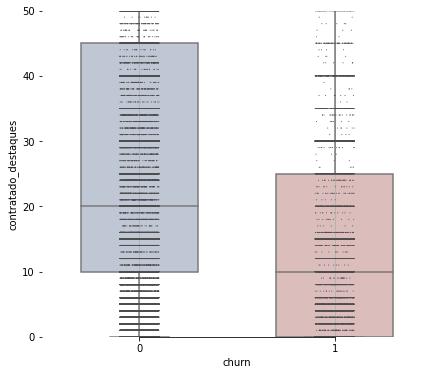

In [249]:
coluna_medida = "contratado_destaques"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 50))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Contratado Ofertas Simples (Relação forte com o churn)

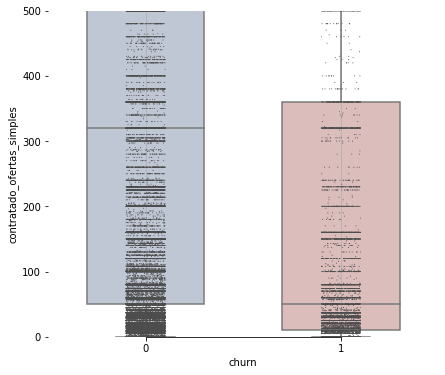

In [250]:
coluna_medida = "contratado_ofertas_simples"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 500))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Utilizado Super Destaque (pode influenciar o churn)

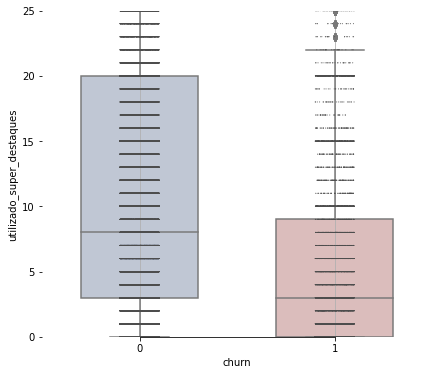

In [251]:
coluna_medida = "utilizado_super_destaques"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 25))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)

### Análise Utilizado Destaque (pode influenciar o churn)

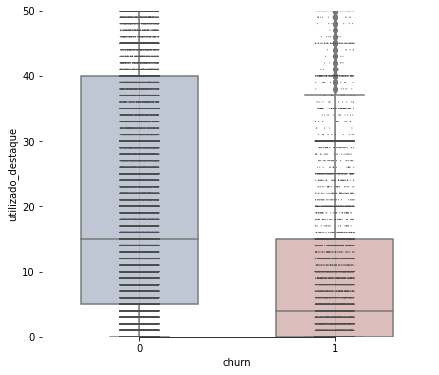

In [252]:
coluna_medida = "utilizado_destaque"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 50))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Utilizado Ofertas Simples (Relação forte com o churn)

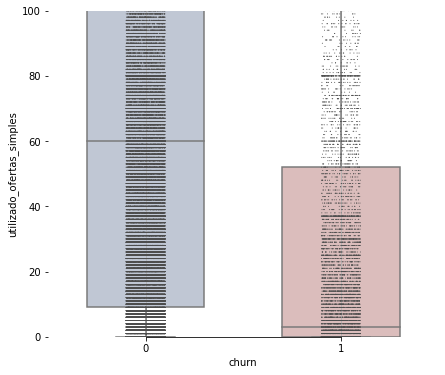

In [253]:
coluna_medida = "utilizado_ofertas_simples"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 100))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Leads Form (Relação forte com o churn)

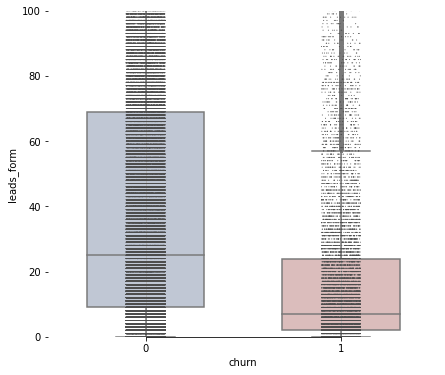

In [254]:
coluna_medida = "leads_form"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 100))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Leads Ver Dato (Relação forte com o churn)

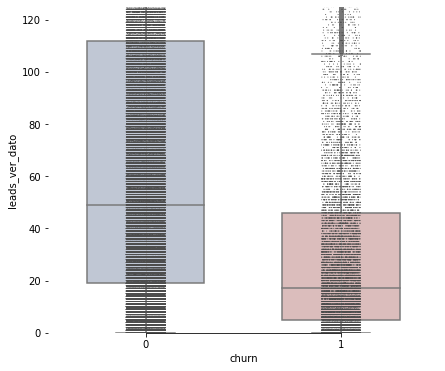

In [255]:
coluna_medida = "leads_ver_dato"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 125))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Leads Total (Relação forte com o churn)

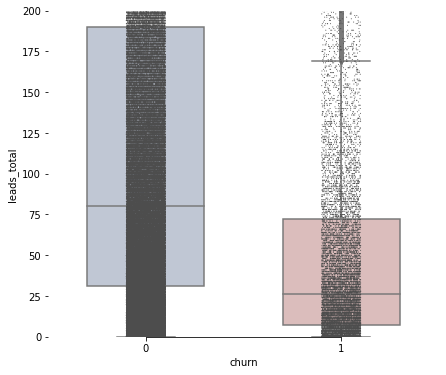

In [256]:
coluna_medida = "leads_total"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 200))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)

### Análise Custo Por Lead Total (Alta correlação com churn. Talvez seja melhor remover)

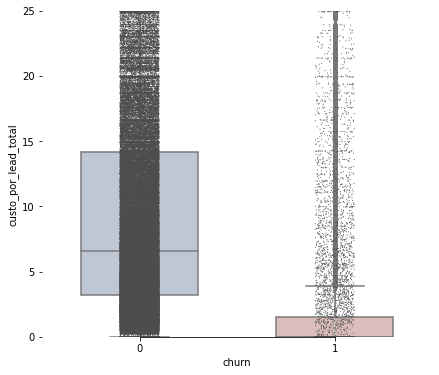

In [257]:
coluna_medida = "custo_por_lead_total"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 25))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)

### Análise Total Contratado (Relação fortíssima com o churn)

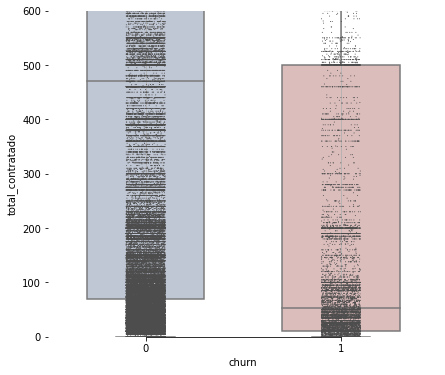

In [258]:
coluna_medida = "total_contratado"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 600))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Total de Listings (Relação forte com o churn)

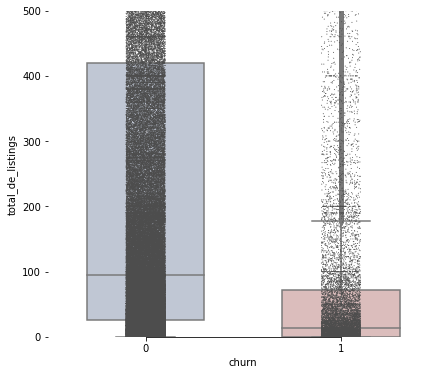

In [259]:
coluna_medida = "total_de_listings"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 500))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Custo Por Listing (Alta correlação com churn. Talvez seja melhor remover)

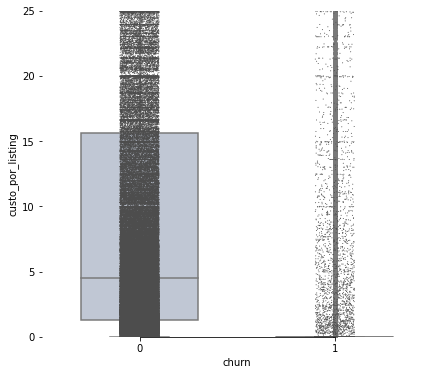

In [260]:
coluna_medida = "custo_por_listing"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 25))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)

### Análise Total Utilizado (Relação fortíssima com o churn)

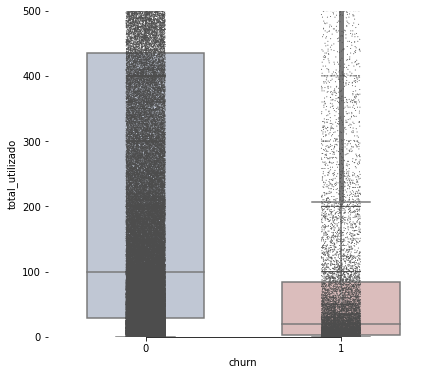

In [261]:
coluna_medida = "total_utilizado"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 500))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)

## Outros

### Em um primeiro momento, iremos substituir todos os valores faltantes pelas medianas de cada série

In [262]:
df.isna().sum()

mes                               0
id_crm                            0
id_navplat                        0
id_sap                            0
regiao                            0
cidade                            2
bairro                        51735
valor_mensal                      0
valor_hoje                        0
faturamento                       0
oficina                           0
frequencia_de_faturamento       692
tipo_de_plano                  3581
contratado_super_destaques        0
contratado_destaques              0
contratado_ofertas_simples        0
utilizado_super_destaques         2
utilizado_destaque                2
utilizado_ofertas_simples         2
executivo_carteira_atual          0
equipe                            0
status_final                      0
possui_midia_ativa_             875
leads_form                       32
leads_ver_dato                   34
leads_total                     183
custo_por_lead_total            526
total_contratado            

### Criação de novo dataframe com somente as colunas relevantes

In [263]:
# pode influenciar tanto que talvez seja melhor remover:
# status_final, valor_hoje, faturamento, custo_por_lead_total, custo_por_listing

# pode influenciar muito:
# pf_pj, faixa_listings, contratado_ofertas_simples, utilizado_ofertas_simples,
# leads_form, leads_ver_dato, leads_total, total_contratado, total_de_listings,
# total_utilizado

# pode influenciar:
# tipo_de_plano, equipe, contratado_super_destaques, utilizado_super_destaques, 
# utilizado_destaque

# pode influenciar pouco:
# possui_midia_ativa_, valor_mensal

In [264]:
df = df[['pf_pj', 'contratado_ofertas_simples', 'utilizado_ofertas_simples',
'leads_form', 'leads_ver_dato', 'leads_total', 'total_contratado', 'total_de_listings',
'total_utilizado', 'equipe', 'contratado_super_destaques', 'utilizado_super_destaques', 
'utilizado_destaque', 'valor_mensal', 'churn']].copy()

In [265]:
df = df.fillna(df.median())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [266]:
df.dtypes

pf_pj                          object
contratado_ofertas_simples      int64
utilizado_ofertas_simples     float64
leads_form                    float64
leads_ver_dato                float64
leads_total                   float64
total_contratado              float64
total_de_listings               int64
total_utilizado               float64
equipe                         object
contratado_super_destaques      int64
utilizado_super_destaques     float64
utilizado_destaque            float64
valor_mensal                  float64
churn                           int64
dtype: object

In [267]:
df.isna().sum()

pf_pj                         0
contratado_ofertas_simples    0
utilizado_ofertas_simples     0
leads_form                    0
leads_ver_dato                0
leads_total                   0
total_contratado              0
total_de_listings             0
total_utilizado               0
equipe                        0
contratado_super_destaques    0
utilizado_super_destaques     0
utilizado_destaque            0
valor_mensal                  0
churn                         0
dtype: int64

### Plot do gráfico para remover as maiores correlações

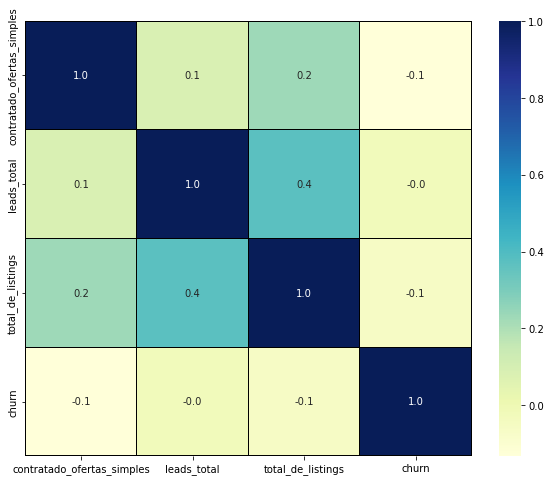

In [270]:
corr = df.corr()

plt.subplots(figsize=(10, 8))
sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt=".1f", linecolor="black", linewidths="0.1", )

### Remoção colunas com muita correlação entre si

In [281]:
df = df[[xxx]].copy()

NameError: ignored

### Isolar a variável de churn (target)

In [182]:
dfChurn = df['churn']

In [183]:
dfChurn.head()

0    0
1    0
2    0
3    0
4    0
Name: churn, dtype: int64

### Dumificação de variáveis numéricas

In [271]:
dfCategorical = pd.get_dummies(df.select_dtypes(include=['object']), columns=['pf_pj', 'equipe'])

In [272]:
dfCategorical.head()

,pf_pj_PF,pf_pj_PJ,equipe_JUMBO,equipe_Mídias,equipe_REGIONAL DF,equipe_RELACIONAMENTO,equipe_RESELLERS,equipe_Regional DF
0,0,1,0,0,0,0,0,1
1,1,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1
4,0,1,0,0,0,0,0,1


### Normalização das variáveis numéricas

In [273]:
Scaler = StandardScaler()

dfNumerical = df.select_dtypes(include=np.number).drop(['churn'], axis = 1)
dfNumerical = pd.DataFrame(Scaler.fit_transform(dfNumerical), columns=dfNumerical.columns)

In [274]:
dfNumerical.head()

,contratado_ofertas_simples,leads_total,total_de_listings
0,-0.791290,-0.055544,-0.253478
1,-0.796367,-0.052847,-0.254521
2,1.229063,0.459513,-0.223236
3,1.229063,0.223108,-0.183088
4,-0.760833,-0.044757,-0.242007


### Concatenação das variáveis normalizadas, dumificadas e da variável target

In [275]:
df = pd.concat([dfNumerical, dfCategorical, dfChurn], axis = 1)

In [276]:
df.head()

,contratado_ofertas_simples,leads_total,total_de_listings,pf_pj_PF,pf_pj_PJ,equipe_JUMBO,equipe_Mídias,equipe_REGIONAL DF,equipe_RELACIONAMENTO,equipe_RESELLERS,equipe_Regional DF,churn
0,-0.791290,-0.055544,-0.253478,0,1,0,0,0,0,0,1,0
1,-0.796367,-0.052847,-0.254521,1,0,0,0,0,0,0,1,0
2,1.229063,0.459513,-0.223236,0,1,0,0,0,0,0,1,0
3,1.229063,0.223108,-0.183088,0,1,0,0,0,0,0,1,0
4,-0.760833,-0.044757,-0.242007,0,1,0,0,0,0,0,1,0


### Divisão do dataset em treino e test

In [277]:
X_train, X_test, y_train, y_test = train_test_split(df, df['churn'], test_size=0.3)


### Balanceamento dos Dados

In [278]:
rus = RandomUnderSampler()

X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

X_train_rus = pd.DataFrame(X_train_rus, columns = X_train.columns)
y_train_rus = pd.Series(y_train_rus)

### Execução do modelo

In [279]:
model = LogisticRegression()
model.fit(X_train_rus, y_train_rus)
pred = model.predict(X_test)
print(metrics.accuracy_score(pred,y_test))

1.0


In [280]:
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     94684
           1       1.00      1.00      1.00      9747

    accuracy                           1.00    104431
   macro avg       1.00      1.00      1.00    104431
weighted avg       1.00      1.00      1.00    104431

